# Advanced Econometrics (JEM217)– Home Assignment 2 (WS 2025)



**Authors: Sebastian Pasz, Vojtěch Dohnal, Tomáš Gabriel**

**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.  
We also set a fixed random seed (`set.seed(123)`) to ensure that all simulated results are fully reproducible.


In [3]:

req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2","gmm")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)
library(gmm)

set.seed(123) 


Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'quantreg' was built under R version 4.4.3"
Loading required package: SparseM

Warning message:
"package 'SparseM' was built under R version 4.4.3"
Warning message:
"package 'lmtest' was built under R version 4.4.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.4.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'sandwich' was built under R version 4.4.3"
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following

## Problem 1 (a)
Simulating the $e_t$ process. And checking length of all 3 variables. We can see that all have length 1000.



In [5]:
T_full <- 1002                 # total length for e_t
e      <- rnorm(T_full, 0, 1)  # e_t ~ N(0,1)

e_t   <- e[3:T_full]           # t = 3..1002  -> length 1000
e_t_1 <- e[2:(T_full-1)]       # t-1
e_t_2 <- e[1:(T_full-2)]       # t-2

print(paste0(
  "Length e_t: ", length(e_t),
  ", t-1: ", length(e_t_1),
  ", t-2: ", length(e_t_2)
))

mu_true   <- 0
theta1_true <- 0.75
theta2_true <- 0.5
sigma2_true <- 1  # variance of e_t in DGP

y <- mu_true + e_t + theta1_true * e_t_1 + theta2_true * e_t_2
T <- length(y)
summary(y)

[1] "Length e_t: 1000, t-1: 1000, t-2: 1000"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.52537 -0.89595  0.06423  0.03472  0.92814  3.91749 

## (b)
Cheching ACF and PACF to see if the model is indeed MA(2)
From ACF we can see that the process looks MA(2) - because the first two lags values are very high (far from zero) and for lags <2 values are close to zero indicating that the proces is not of higher order.

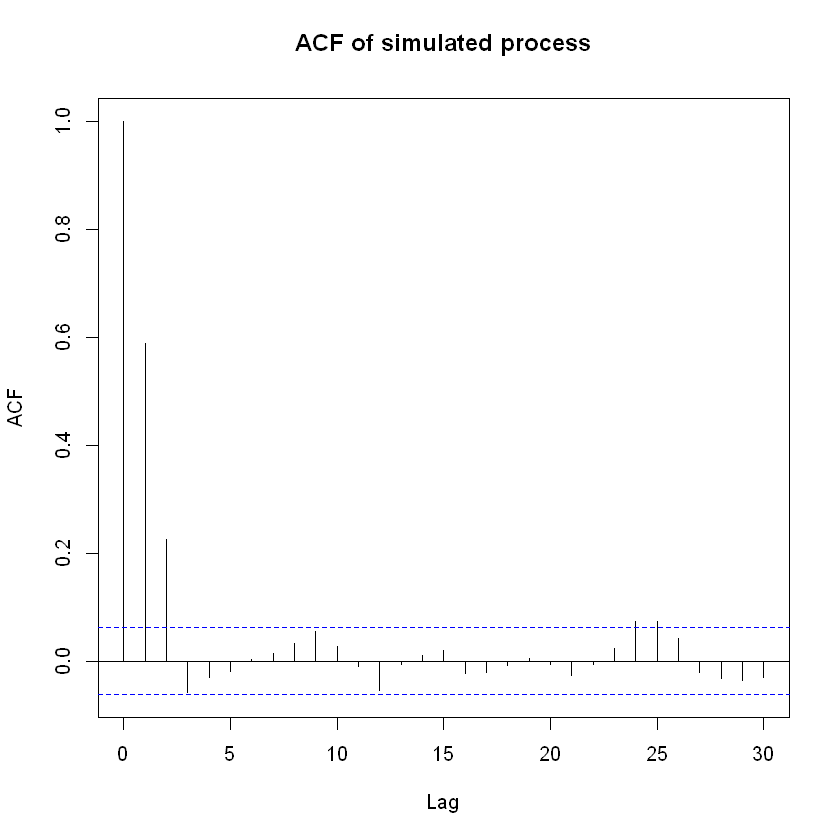

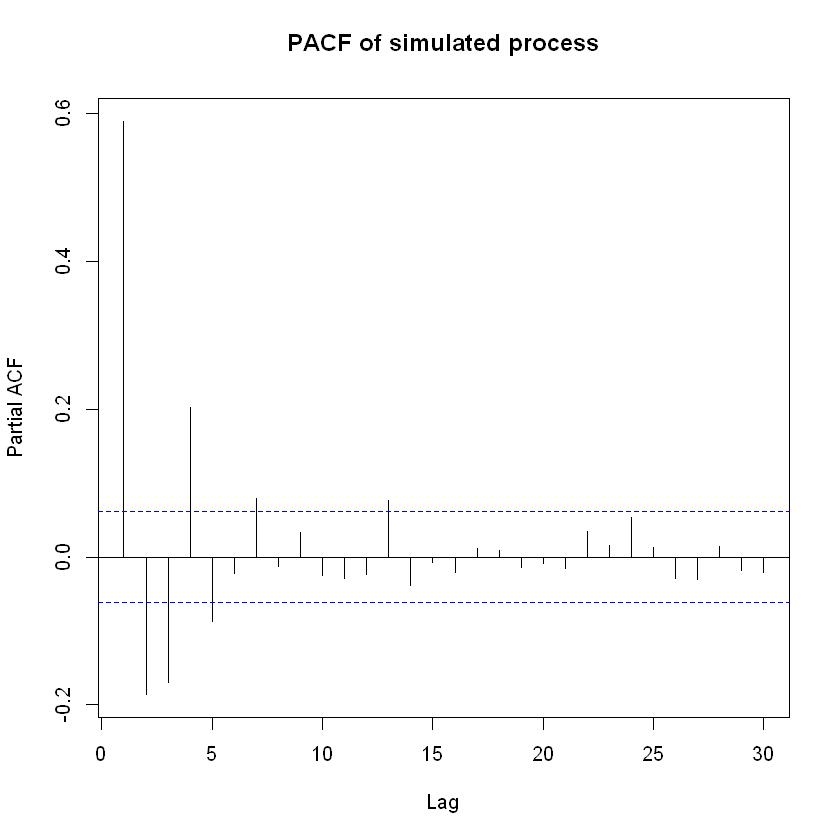

In [6]:
par(bg = "white")
acf(y, main = "ACF of simulated process")
pacf(y, main = "PACF of simulated process")

## (c)

Obtaining the moment conditions and creating a function to use them.


In [7]:
max_lag <- 4

y_lag0 <- y[(1+max_lag):T]
y_lag1 <- y[(1+max_lag-1):(T-1)]
y_lag2 <- y[(1+max_lag-2):(T-2)]
y_lag3 <- y[(1+max_lag-3):(T-3)]
y_lag4 <- y[(1+max_lag-4):(T-4)]

stopifnot(
  length(y_lag0) == length(y_lag1),
  length(y_lag0) == length(y_lag2),
  length(y_lag0) == length(y_lag3),
  length(y_lag0) == length(y_lag4)
)


data_gmm <- data.frame(
  y  = y_lag0,
  y1 = y_lag1,
  y2 = y_lag2,
  y3 = y_lag3,
  y4 = y_lag4
)


ma2_moments <- function(theta, data) {
  mu   <- theta[1]
  th1  <- theta[2]
  th2  <- theta[3]
  sig2 <- theta[4]

  yt <- data$y
  y1 <- data$y1
  y2 <- data$y2
  y3 <- data$y3
  y4 <- data$y4

  u  <- yt - mu
  u1 <- y1 - mu
  u2 <- y2 - mu
  u3 <- y3 - mu
  u4 <- y4 - mu

  gamma0 <- (1 + th1^2 + th2^2) * sig2
  gamma1 <- (th1 + th1 * th2)  * sig2
  gamma2 <- th2 * sig2
  gamma3 <- 0
  gamma4 <- 0

  m1 <- u                         # E[u_t] = 0
  m2 <- u^2    - gamma0           # Var
  m3 <- u*u1   - gamma1           # Cov lag 1
  m4 <- u*u2   - gamma2           # Cov lag 2
  m5 <- u*u3   - gamma3           # Cov lag 3
  m6 <- u*u4   - gamma4           # Cov lag 4

  cbind(m1, m2, m3, m4, m5, m6)
}


theta_start <- c(
  mu   = mean(y),
  th1  = 0.3,
  th2  = 0.2,
  sig2 = var(y) / 3
)

head(ma2_moments(theta_start, data_gmm))
summary(as.vector(ma2_moments(theta_start, data_gmm)))


m1,m2,m3,m4,m5,m6
1.77714271,2.5186330,3.01742616,1.53386433,1.93661421,1.90353535
-0.09655769,-0.6302798,-0.37536420,-0.28822158,-0.08949035,-0.10522228
-1.43990678,1.4337283,-0.06473333,-2.67212395,-2.60993022,-1.33451580
-1.62804833,2.0109381,2.14047043,0.04399648,-2.89327422,-2.95094974
0.51169279,-0.3777737,-1.03682799,-0.84999403,-0.04940787,0.90935111
1.02032808,0.4014662,0.31832712,-1.77434755,-1.46917733,-0.09852053


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.0144 -0.5349  0.0406  0.3272  0.9376 14.4363 

## (d)

We estimate the MA(2) model by GMM under two configurations:

1. One-step GMM with **identity weighting matrix** (`wmatrix = "ident"`).
2. Two-step GMM with **optimal weighting matrix** (`wmatrix = "optimal"`).

The true DGP parameters are:
$
\mu = 0,\quad \theta_1 = 0.75,\quad \theta_2 = 0.5,\quad \sigma^2 = 1.
$

---

#### One-step GMM with identity weighting matrix


- $\mu$ is **not statistically significant** (p ≫ 0.05), which is consistent with the true mean of zero.
- $\theta_1$ and $\theta_2$ are **highly significant**, confirming the presence of MA(2) dynamics. $\theta_1$ is close to the true 0.75; $\theta_2$ is somewhat biased downward relative to 0.5.
- $\sigma^2$ is significantly different from zero and close to the true variance of 1.

J-test for overidentifying restrictions:

- J = 15.15, df = 2, p = 0.000513  
- We **reject** $H_0: E[g(\theta)] = 0$.  
  This indicates that, with the identity weighting matrix, the set of moment conditions is not jointly consistent with the data. In other words, the model plus chosen moments are rejected under this weighting scheme.

---

#### Two-step GMM with optimal weighting matrix

- $\mu$ remains **insignificant**, again consistent with a zero-mean process.
- $\theta_1$ and $\theta_2$ are **very precisely estimated** and now lie very close to their true values (0.75 and 0.5). Standard errors are lower than under the identity weighting, reflecting the efficiency gains of optimal GMM.
- $\sigma^2$ is almost exactly 1, matching the true innovation variance.

J-test for overidentifying restrictions:

- J = 2.45, df = 2, p = 0.293  
- We **do not reject** $H_0: E[g(\theta)] = 0$.  
  Under the optimal weighting matrix, the overidentifying restrictions are satisfied; the MA(2) specification and the chosen set of moments are jointly consistent with the data.


In [9]:


gmm_id <- gmm(
  g        = ma2_moments,
  x        = data_gmm,
  t0       = theta_start,
  wmatrix  = "ident",     
  type     = "twoStep"     
)

summary(gmm_id)
specTest(gmm_id)           # J-test


gmm_opt <- gmm(
  g        = ma2_moments,
  x        = data_gmm,
  t0       = coef(gmm_id), 
  wmatrix  = "optimal",
  type     = "twoStep"     
)

summary(gmm_opt)
specTest(gmm_opt)


Call:
gmm(g = ma2_moments, x = data_gmm, t0 = theta_start, type = "twoStep", 
    wmatrix = "ident")


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
      Estimate    Std. Error  t value     Pr(>|t|)  
mu    2.7810e-02  8.5086e-02  3.2685e-01  7.4378e-01
th1   7.0166e-01  3.6526e-02  1.9210e+01  3.0723e-82
th2   3.6612e-01  7.8457e-02  4.6665e+00  3.0630e-06
sig2  1.0433e+00  5.0127e-02  2.0812e+01  3.3498e-96

J-Test: degrees of freedom is 2 
                J-test      P-value   
Test E(g)=0:    1.5149e+01  5.1338e-04

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  227 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 2  ## 

                J-test      P-value   
Test E(g)=0:    1.5149e+01  5.1338e-04



Call:
gmm(g = ma2_moments, x = data_gmm, t0 = coef(gmm_id), type = "twoStep", 
    wmatrix = "optimal")


Method:  twoStep 

Kernel:  Quadratic Spectral(with bw =  3.01264 )

Coefficients:
      Estimate     Std. Error   t value      Pr(>|t|)   
mu     2.3244e-02   8.5012e-02   2.7342e-01   7.8453e-01
th1    7.3398e-01   3.2605e-02   2.2511e+01  3.2204e-112
th2    4.8504e-01   4.0229e-02   1.2057e+01   1.7814e-33
sig2   9.9261e-01   4.7231e-02   2.1016e+01   4.6526e-98

J-Test: degrees of freedom is 2 
                J-test   P-value
Test E(g)=0:    2.45317  0.29329

Initial values of the coefficients
        mu        th1        th2       sig2 
0.02772721 0.70168832 0.36612202 1.04318868 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  251 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 2  ## 

                J-test   P-value
Test E(g)=0:    2.45317  0.29329


## Problem 3: Endogeneity
### Data Simulation


In [77]:
library(AER)
library(systemfit)

nobs = 300

# Generating the random variables according to the instructions 

# instruments
z1 = rnorm(nobs,2,3)
z2 = rnorm(nobs,2,1.5)
z3 = rnorm(nobs,0,2)
z4 = rnorm(nobs,1.8,2.5)    

# generate the error
e1 = rnorm(nobs,0,1.5)
e2 = rnorm(nobs,0,1.5)
e3 = rnorm(nobs,0,1.5)

# create the explanatory variables
x1 = 0.3 * z1 - z2 + 0.9 * z4 + 0.75 * e1
x2 = 0.75 * z2 + 0.75 * e2
x3 = rnorm(nobs,0,1)

# create the dependent variable
y = 1 + 2.5 * x1 - x2 + 0.45 * x3 + e3

### a)

<!-- The endogeneity problem in our model comes from the fact that the variable x1 in our model is correlated with x2 through z2 and since x2 is not controled for in the model i.e. the error term contains it, therefore we have correlated error ter with an explanatory variable. The important correlations could be seen in the table below. The difference between x1 and x2: - x1: depends on 4 other random variables out of which one also determines the variable present in the error -> x1 is an endogenous variable in our model - x3: is randomly drawn from the standard normal distribution and therefore is completely independent of all other random vars -> exogenous explanatory variable We expect the OLS estimation to be biased because of the above described endogeneity -->

The endogeneity problem in our model arises because the regressor x1 is correlated with x2 through their shared dependence on z2. Since x2 is omitted from the estimated model, it becomes part of the error term. As a result, the error term is correlated with an explanatory variable (x1), which violates one of the key OLS assumptions. This can also be observed in the correlation table below.

Regarding the difference between x1 and x3:

x1 depends on four other random variables, one of which (z2) also helps determine x2, a variable contained in the error term. Therefore, x1 is an endogenous regressor in our model.

x3 is drawn independently from a standard normal distribution and is therefore completely unrelated to all other random variables. This makes x3 an exogenous explanatory variable.

Because of this endogeneity, we expect the OLS estimate of the coefficient on x1 to be biased.

In [78]:
df <- data.frame(z1,z2,z3,z4,e1,e2,e3,x1,x2,x3,y)

# Upper correlation matrix
cor_mat <- round(cor(df), 4)
upper_mat <- cor_mat
upper_mat[lower.tri(upper_mat)] <- NA
upper_mat

,z1,z2,z3,z4,e1,e2,e3,x1,x2,x3,y
z1,1,-0.0656,-0.0382,0.0139,-0.1165,-0.0781,0.0286,0.2833,-0.1019,-0.0124,0.2791
z2,NA,1.0000,-0.0408,0.1097,-0.0176,-0.0043,-0.0467,-0.4338,0.6993,-0.0387,-0.5336
z3,NA,NA,1.0000,0.0440,0.0291,0.0295,-0.0180,0.0533,-0.0076,0.0425,0.0484
z4,NA,NA,NA,1.0000,0.0780,0.0735,-0.0286,0.7383,0.1296,0.0745,0.6392
e1,NA,NA,NA,NA,1.0000,-0.0470,0.0295,0.3990,-0.0459,-0.0563,0.3706
e2,NA,NA,NA,NA,NA,1.0000,-0.0823,0.0188,0.7118,-0.0499,-0.1353
e3,NA,NA,NA,NA,NA,NA,1.0000,0.0201,-0.0916,-0.0400,0.2140
x1,NA,NA,NA,NA,NA,NA,NA,1.0000,-0.2913,0.0517,0.9623
x2,NA,NA,NA,NA,NA,NA,NA,NA,1.0000,-0.0629,-0.4715
x3,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.0000,0.1017


### b)

In [79]:
ols <- lm(y ~ x1 + x3, data = df)
summary(ols)


Call:
lm(formula = y ~ x1 + x3, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8929 -1.4878  0.0931  1.3579  6.1948 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.60314    0.13030  -4.629  5.5e-06 ***
x1           2.66291    0.04305  61.857  < 2e-16 ***
x3           0.46479    0.13836   3.359 0.000883 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.24 on 297 degrees of freedom
Multiple R-squared:  0.9287,	Adjusted R-squared:  0.9282 
F-statistic:  1935 on 2 and 297 DF,  p-value: < 2.2e-16


<!--From the results we can validate our previous answer. The beta1 coefficient is significantly biased up due to the endogeneity. We can also indicate large impresicion present within the intercept. The suprising result is that while the value of the beta3 is close to the real value, the standard error is really high which is unexpected. According to the adjusted R2 the model explains approximately 93% of the variation of the dependent variable. -->
Based on the estimation results, we can validate our earlier conclusion about endogeneity. The coefficient β₁ is clearly biased upward, which is consistent with the endogeneity problem discussed previously. We can also observe substantial imprecision in the estimate of the intercept. A surprising finding is that although the estimated value of β₃ is close to the true value, its standard error is very large, which is unexpected. According to the adjusted R², the model explains approximately 93% of the variation in the dependent variable.

### c)

<!--The 'goodness' of an instrument is based on following two criteria:
- Relevance: the instrument has to reflect the desired relationship and therefore Cov(x,z) cannot be zero, in fact the higher the better 
- Exogeneity: since we are trying to deal with endogeneity, the instrument has to be exogenous Cov(e, z) has to be zero or at least close to zero. 

The instrument candidates: 
- z1 and z4: these two satisfy the above conditions well judging form the correlation matrix as well as the equations in the intructions. Both are present in the x1 eq i.e. they are relevant, and are not present in the x2 eq meaning they are exogenous.
-z3: this canditate seems to be irrelevant for our case because it is not present in the x1 eq, therefore eventhough it satisfies the exogeneity condition, we can rule it out 
-z2: this variable causes the endogeneity problem therefore while relevant (is present in the x1 eq), we definitely have to rule this one out, because that is the source of out problem 

The results of the relevance test could be seen below. The test verified that the insturments are relevent, since the null hypotheses was rejected. These results are are in line with our expectation based on the equations from the instructions. -->
The quality of an instrument is determined by two key conditions:

Relevance: the instrument must be correlated with the endogenous regressor, so Cov(x, z) ≠ 0. In practice, the stronger this correlation, the better.

Exogeneity: the instrument must be uncorrelated with the structural error term. Thus Cov(e, z) = 0, or at least very close to zero.

Assessment of the instrument candidates:

z1 and z4:
These variables satisfy both relevance and exogeneity based on the correlation matrix and the model equations. Both enter the equation for x₁, making them relevant, and neither appears in the x₂ equation, so they are exogenous.

z3:
This candidate appears to be irrelevant because it does not enter the equation for x₁. Even though it satisfies exogeneity, it cannot be used since it does not explain x₁.

z2:
This variable is the source of the endogeneity problem. While it is relevant (since it appears in x₁), we must rule it out because it also enters x₂ and therefore violates exogeneity.

The results of the relevance test are shown below. The test confirms that the instruments are relevant, since the null hypothesis was rejected. These statistical findings are consistent with our expectations based on the model equations.

In [80]:
IV_rel_test <- lm(x1 ~ z1 + z4 + x3, data = df)
summary(IV_rel_test)

linearHypothesis(IV_rel_test, c("z1 = 0", "z4 = 0"))


Call:
lm(formula = x1 ~ z1 + z4 + x3, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-6.030 -1.166 -0.081  1.166  6.297 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.94000    0.15597 -12.438  < 2e-16 ***
z1           0.28963    0.03803   7.617 3.53e-13 ***
z4           0.86981    0.04257  20.431  < 2e-16 ***
x3           0.00106    0.11554   0.009    0.993    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.868 on 296 degrees of freedom
Multiple R-squared:  0.6197,	Adjusted R-squared:  0.6158 
F-statistic: 160.8 on 3 and 296 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,298,2708.189,NA,NA,NA,NA
2,296,1032.788,2,1675.401,240.0875,1.089295e-62


### d)

In [81]:
IV_reg = ivreg(y ~ x1 + x3 | z4 + x3, data = df)
summary(IV_reg)

twoSLS = ivreg(y ~ x1 + x3 | x3 + z1 + z4, data = df)
summary(twoSLS)


Call:
ivreg(formula = y ~ x1 + x3 | z4 + x3, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-6.347 -1.619 -0.151  1.504  7.257 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.51640    0.13968  -3.697 0.000260 ***
x1           2.38646    0.06229  38.310  < 2e-16 ***
x3           0.51070    0.14782   3.455 0.000631 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.391 on 297 degrees of freedom
Multiple R-Squared: 0.9188,	Adjusted R-squared: 0.9183 
Wald test: 752.8 on 2 and 297 DF,  p-value: < 2.2e-16 



Call:
ivreg(formula = y ~ x1 + x3 | x3 + z1 + z4, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-6.27402 -1.52587 -0.06596  1.40001  7.02953 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.53033    0.13698  -3.872 0.000133 ***
x1           2.43084    0.05735  42.388  < 2e-16 ***
x3           0.50333    0.14509   3.469 0.000599 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.347 on 297 degrees of freedom
Multiple R-Squared: 0.9217,	Adjusted R-squared: 0.9212 
Wald test:   918 on 2 and 297 DF,  p-value: < 2.2e-16 


<!--Based on the previous point and the correlation matrix we have chosen the z4 variable as our instrument.
From the results of the IV and 2SLS regressions, we can see that all the coefficients reported by 2SLS are closer to the true values including the coefficient and also the standard errors are lower for all of the obtained coefficients. 
This result is not very surprising, since in the 2SLS we also include the additional z1 variable which is also a relevant instrument which was just not chosen in the previous step. -->

Based on the previous analysis and the correlation matrix, we selected z4 as our instrument.
From the IV and 2SLS regression results, we observe that all coefficients obtained from the 2SLS estimation are closer to the true parameter values. In addition, the standard errors are lower for all estimated coefficients.

This outcome is not surprising, since the 2SLS procedure uses an additional instrument, z1, which is also relevant but was not chosen in the single-instrument IV regression. Including this extra valid instrument naturally leads to more precise estimates.

### e)

In [82]:
ols_model   = systemfit(y ~ x1 + x3, data = df, method = "OLS")
iv_model    = systemfit(y ~ x1 + x3, data = df, method = "2SLS", inst = ~ x3 + z1 + z4)

hausman.systemfit(iv_model, ols_model)


	Hausman specification test for consistency of the 3SLS estimation

data:  df
Hausman = 37.517, df = 3, p-value = 3.577e-08


The Hausmann test proves our endogeneity concerns. The null hypothesis of this test, that is, the exogeneity, is strongly rejected at all conventional levels. This result supports the conclusion that OLS is inconsistent in this setting and that an IV/2SLS approach is necessary.

### f)

In [83]:
nobs = 30000

# Generating the random variables according to the instructions 

# instruments
z1 = rnorm(nobs,2,3)
z2 = rnorm(nobs,2,1.5)
z3 = rnorm(nobs,0,2)
z4 = rnorm(nobs,1.8,2.5)    

# generate the error
e1 = rnorm(nobs,0,1.5)
e2 = rnorm(nobs,0,1.5)
e3 = rnorm(nobs,0,1.5)

# create the endogenous variables
x1 = 0.3 * z1 - z2 + 0.9 * z4 + 0.75 * e1
x2 = 0.75 * z2 + 0.75 * e2
x3 = rnorm(nobs,0,1)

# create the dependent variable
y = 1 + 2.5 * x1 - x2 + 0.45 * x3 + e3

df_2 <- data.frame(z1,z2,z3,z4,e1,e2,e3,x1,x2,x3,y)


model_1_ols <- lm(y ~ x1 + x3, data = df_2)
summary(model_1_ols)


twoSLS = ivreg(y ~ x1 + x3 | x3 + z1 + z4, data = df_2)
summary(twoSLS)


Call:
lm(formula = y ~ x1 + x3, data = df_2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.5920 -1.4384 -0.0015  1.4423  8.5772 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.544203   0.012341  -44.10   <2e-16 ***
x1           2.679197   0.004027  665.39   <2e-16 ***
x3           0.452706   0.012289   36.84   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.132 on 29997 degrees of freedom
Multiple R-squared:  0.9367,	Adjusted R-squared:  0.9367 
F-statistic: 2.22e+05 on 2 and 29997 DF,  p-value: < 2.2e-16



Call:
ivreg(formula = y ~ x1 + x3 | x3 + z1 + z4, data = df_2)

Residuals:
      Min        1Q    Median        3Q       Max 
-9.126472 -1.474434  0.004661  1.482334  9.813529 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.505357   0.012770  -39.58   <2e-16 ***
x1           2.497998   0.005267  474.24   <2e-16 ***
x3           0.451613   0.012698   35.57   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.203 on 29997 degrees of freedom
Multiple R-Squared: 0.9324,	Adjusted R-squared: 0.9324 
Wald test: 1.13e+05 on 2 and 29997 DF,  p-value: < 2.2e-16 


<!--As can be seen from the results, the difference between the estimated and the true beta3 is for both methods actually very close with very similar standard errors. While for beta1, as expected, the OLS reports biased up results at higher number of observations proving that it is in fact inconsistent. On the other hand, 2SLS correctly converges to the true value as the observations increase.-->

As can be seen from the results, the difference between the estimated and the true β₃ values is very small for both OLS and 2SLS, with similar standard errors. In contrast, for β₁, as expected, the OLS estimates show upward bias at higher sample sizes, demonstrating that OLS is inconsistent for this coefficient. On the other hand, the 2SLS estimates correctly converge to the true β₁ value as the number of observations increases.